## 参数的更新

训练神经网络的目的是找到使损失函数值尽可能小的参数，这是寻找最优参数的问题，这个过程叫最优化(Optimization)，常见的优化算法：SGD、Momentum、AdaGrad、Adam等

### SGD 随机梯度下降

$$\boldsymbol{W} \leftarrow \boldsymbol{W}-\eta \frac{\partial L}{\partial \boldsymbol{W}}$$

In [1]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

SGD的缺点是，如果函数的形状非均向(anisotropic)，比如呈延伸状，搜索的路径就会非常低效。SGD低效的根本原因是，**梯度的方向并没有指向最小值的方向**。

### Monentum

Monentum是动量的意思，来源于物理，引入了一个新变量：物理上的速度 $v$ 

$$\begin{array}{c}{\boldsymbol{v} \leftarrow \alpha \boldsymbol{v}-\eta \frac{\partial L}{\partial \boldsymbol{W}}} \\ {\boldsymbol{W} \leftarrow \boldsymbol{W}+\boldsymbol{v}}\end{array}$$

这种方式物理上的意义表示物体在梯度的方向上受力，在这个力作用下，物体速度增加

In [2]:
import numpy as np

class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val) # 保存与参数结构相同的值
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### AdaGrad 学习率衰减

AdaGrad会为参数的每个元素适当地调整学习率

$$\begin{array}{c}{\boldsymbol{h} \leftarrow \boldsymbol{h}+\frac{\partial L}{\partial \boldsymbol{W}} \odot \frac{\partial L}{\partial \boldsymbol{W}}} \\ {\boldsymbol{W} \leftarrow \boldsymbol{W}-\eta \frac{1}{\sqrt{\boldsymbol{h}}} \frac{\partial L}{\partial \boldsymbol{W}}}\end{array}$$

引入新变量 $h$，保存以前所有梯度值的平方和，更新参数时乘以 $\frac{1}{\sqrt{h}}$ 调整学习率的大小

In [3]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

### Adam

Momentum参照小球在碗中滚动的物理规则进行移动，AdaGrad为参数的每个元素适当地调整更新步伐。Adam方法的基本思路就是将这两个方法融合在一起

### 如何选择使用哪种优化器

并不存在能在所有问题中都表现良好的方法。这4 种方法各有各的特点，都有各自擅长解决的问题和不擅长解决的问题。很多研究中至今仍在使用SGD。Momentum和AdaGrad也是值得一试的方法。最近，很多研究人员和技术人员都喜欢用Adam

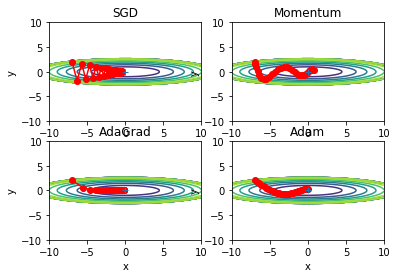

In [5]:
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *

def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0 * y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    
    mask = Z >=7
    Z[mask] = 0
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")

plt.show()

### 几种优化器对于MNIST数字识别的对比

===========iteration:0===========
SGD:2.3280576009529175
Momentum:2.4739124576041256
AdaGrad:1.962089308280655
Adam:2.189898227816838
===========iteration:100===========
SGD:1.4770711524835336
Momentum:0.3750513807655942
AdaGrad:0.14386005985292194
Adam:0.2431257102813854
===========iteration:200===========
SGD:0.8323470608215635
Momentum:0.2935547222084742
AdaGrad:0.10191874661805468
Adam:0.18070000682091658
===========iteration:300===========
SGD:0.7066660694013265
Momentum:0.2803330597926956
AdaGrad:0.12147061842609504
Adam:0.21580267295921784
===========iteration:400===========
SGD:0.5321839889958265
Momentum:0.26002140700883786
AdaGrad:0.09752254836229464
Adam:0.17327291456018712
===========iteration:500===========
SGD:0.3718806974159401
Momentum:0.11451265741991454
AdaGrad:0.04358097826863102
Adam:0.04927981813160122
===========iteration:600===========
SGD:0.43001908413049894
Momentum:0.17338463760827966
AdaGrad:0.10424322157135833
Adam:0.15328523958052775
===========iteration:70

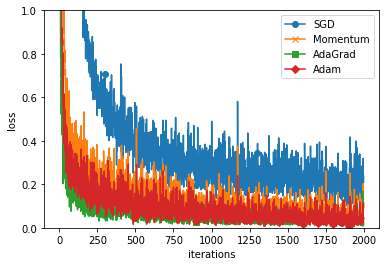

In [6]:
import os
import sys
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, train_loss[key], marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()

## 权重的初始值